# Vehicle Counting and Classification
<i> Innovation Lab Project WiSe 2020/21 by Laurence-Sebastian Alscher, Mohammed Goha and Maria Kaltenbrunner </i>

### Description
We are classifying vehicles on images. We decided to use an implementation of the YOLO algorithm called Yet Another Darknet 2 Keras. The YOLO algorithm has the benefit of offering very quick object detection enabling even real-time detection. However, training a YOLO model requires high computational cost. Therefore it is common to use weights from a pre-trained model, which we have done. We have taken YOLO weights from the official YOLO website from a model trained on the Coco (Common Objects in Context) Dataset.

The YOLO algorithm divides each image into a grid of size GxG, then applying a classification algorithm on each grid cell.
An object is detected in the grid cell where the center of its bounding box lies. In case there might be more than one object in a grid cell, anchor boxes can be specified to be able to find more than one bounding box.

If anchor boxes A are specified, the algorithm looks for one of each specified anchor boxes in the grid cell.

Each bounding box B is given as a list of five values (x, y, w, h, confidence).
The (x, y) corrdinates give the center of the box relative to the location of the grid cell. The (w,h) dimensions represent the box dimension. All four values are normalized to [0,1].
The confidence is a probability which represents how sure the model is that there is any object in this grid cell.

The probability of an object to be of a certain class is computed if the grid cell probably contains any object. The class predictions P are a list of probabilites for each looked for class (p1, p2, p3, ...).

Since the bounding boxes are looked for in each grid cell, the YOLO Algorithm returns a tensor of G x G x A x (B + P).
Therefore in a grid of 19x19 with 5 anchor boxes and 2 classes to be predicted, the tensor returned by the algorithm would be of shape (19, 19, 5, 7).

### Hard Facts
We are trying to detect 5 classes: bicycle, car, motorbike, bus, truck. Since the model was trained on 80 classes, we have to use all of them, therefore additional objects might be detected when testing.

## Preparations

In [32]:
# Import the necessary libraries
import os
import numpy as np
import tensorflow as tf
from keras import backend as K

from keras.models import load_model

from utils import yolo_utils
from yad2k.models import keras_yolo as yad2k
from yad2k.utils import draw_boxes as yad2kutils

from matplotlib import image
from matplotlib import pyplot as plt

%matplotlib inline

## Functions

### Function to filter the bounding boxes by threshold on class scores
The YOLO algorithm returns a massive tensor. A first filtering is done using a threshold on class scores, therefore removing all boxes which have a very low probability of showing any of the objects looked for. <br>
<br>Step 1: The class probabilities represent how likely each of the classes are correct for this box GIVEN that there is any object. To get a more absolute score of the classes being in the image we compute a score of these two arguments.
<br>Step 2: The highest score for each grid cell has to be found out to decide whether it is under the threshold. For that, the maximum of the last axis is taken by the Keras max() function and its index found by the Keras argmax() function.
<br>Step 3: To return only the boxes we want to keep, we first have to check which of the maximum scores holds up to the threshold. We therefore create a mask, which we can later use on the boxes to know which to return.
<br>Step 4: By appling the mask to the tensors, we find our wanted filtered boxes, the highest class score for each box and the class that is probably depicted in that box.

In [2]:
def filter_boxes(confidence, boxes, class_probs, threshold = 0.6):
    """
    Filters the bounding boxes based on their probabilities and a certain threshold.
    
    Parameters:
    boxes -- tensor of shape (19, 19, 5, 4), coordinates and dimensions of each box in each grid cell
    box_confidence -- tensor of shape (19, 19, 5, 1), confidence for each box in each grid cell
    box_class_probs -- tensor of shape (19, 19, 5, 80), probabilities for each class for each box in each grid cell
    threshold -- float, if no class probability of a box is higher than threshold the box will be removed
    
    Returns:
    final_scores -- tensor of shape (None,), containing the score of class probability for each box chosen
    final_boxes -- tensor of shape (None,4), containing the coordinates of each box chosen
    final_classes -- tensor of shape (None,), containing the index of the most probable class for each box chosen
    """
    
    # Step 1: Compute a score for each box
    scores = np.multiply(confidence, class_probs)
    
    # Step 2: Find the highest score and its corresponding index for each box
    class_scores = K.max(scores, axis=-1)
    classes = K.argmax(scores, axis=-1)
    
    # Step 3: Create a mask to filter the boxes based on the threshold
    filtering_mask = K.greater_equal(class_scores, threshold)
    
    # Step 4: Apply the mask to the scores, boxes and classes
    # Find the scores of the boxes which we want to keep
    final_scores = tf.boolean_mask(class_scores, filtering_mask)
    # Find the boxes we want to keep
    final_boxes = tf.boolean_mask(boxes, filtering_mask)
    # Find the classes of the boxes we want to keep
    final_classes = tf.boolean_mask(classes, filtering_mask)
    
    # Return the three tensors with the data of the filtered boxes
    return final_scores, final_boxes, final_classes


In [3]:
# Test the filter boxes function
# Test code taken from Autonomous Driving - Car detection (see links below)
with tf.Session() as test_a:
    box_confidence = tf.random_normal([19, 19, 5, 1], mean=1, stddev=4, seed = 1)
    boxes = tf.random_normal([19, 19, 5, 4], mean=1, stddev=4, seed = 1)
    box_class_probs = tf.random_normal([19, 19, 5, 80], mean=1, stddev=4, seed = 1)
    scores, boxes, classes = filter_boxes(box_confidence, boxes, box_class_probs, threshold = 0.5)
    print("scores[2] = " + str(scores[2].eval()))
    print("boxes[2] = " + str(boxes[2].eval()))
    print("classes[2] = " + str(classes[2].eval()))
    print("scores.shape = " + str(scores.shape))
    print("boxes.shape = " + str(boxes.shape))
    print("classes.shape = " + str(classes.shape))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
scores[2] = 10.750582
boxes[2] = [ 8.426533   3.2713668 -0.5313436 -4.9413733]
classes[2] = 7
scores.shape = (?,)
boxes.shape = (?, 4)
classes.shape = (?,)


### Function to filter intersection over union

This function is generally used in object detection, independent of the model used.
It uses basic functionality of set theory to evaluate how similar two boxes are,
therefore if one of the boxes is the actual, right one it can determine how
well the prediction worked. It would be used in the non max suppression. However, since we are using the built-in non max suppression by Tensorflow, it is more for understanding than application in this case.

In [4]:
def intersection_over_union(box1, box2):
    """
    Calculates the intersection over union of the actual (given) bounding box and the predicted bounding box 
    to be able to evaluate the predicted result.
    If the intersection over union is greater than a certain threshold, it is considered good enough.
    
    The parameters are the two boxes to be compared, their order doesn't influence the result.
    Parameters:
    box1 -- list object with coordinates (x1, y1, x2, y2)
    box2 -- list object with coordinates (x1, y1, x2, y2)
    
    Returns:
    iou -- float, the computed intersection over union of the two boxes given
    """
    # To get the coordinates of the intersection
    # Looking for the maximum to get the upper border and for the minimum to get the lower border
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    
    # Compute the area of the intersection
    intersection = (x2-x1) * (y2-y1)
    
    # Compute the area of the union
    # Rule for computing the union of two sets knowing the intersection: Union(A,B) = A + B - Intersection(A,B)
    box1_area = (box1[3] - box1[1])*(box1[2] - box1[0])
    box2_area = (box2[3] - box2[1])*(box2[2] - box2[0])
    union = (box1_area + box2_area) - intersection
    
    # Compute the intersection over union
    iou = intersection/union
    
    return iou

In [5]:
# Test the IoU function
box1 = (4, 2, 8, 6)
box2 = (2, 4, 9, 8)

print("The intersection over union of our two boxes is", intersection_over_union(box1, box2))

# We can also show that the order of the boxes given as arguments doesn't matter
print("Are the results the same when given the boxes in different order?", intersection_over_union(box1, box2) == intersection_over_union(box2, box1))

The intersection over union of our two boxes is 0.2222222222222222
Are the results the same when given the boxes in different order? True


### Function to filter the bounding boxes by non-max-suppression (using intersection over union)
For each object more than one possible bounding box may be detected. To find out the one of these which best focuses on the object and to suppress the remaining ones, this function first takes the box with the highest score (computed in the filter function), computes the intersection over union of this box with the other boxes and then suppresses those of the other boxes, which have a iou with it above a certain threshold. Therefore, the most confident box remains while all boxes which probably mark the same object (but with less confidence) are removed. 
<br>For this function we use a built-in tensorflow function to reduce complexity. Therefore the main object is to prepare the right parameters for the built-in function and later filter our boxes, classes and scores based on the indices returned by that function.

In [6]:
def non_max_suppression(scores, boxes, classes, max_boxes = 10, threshold = 0.5):
    """
    Results in only one box per object by choosing the box with the highest probability,
    suppressing all boxes which have a high intersection over union with this box (which are similar).
    This function uses the tensorflow non max suppression method.
    
    Parameters:
    scores -- tensor of shape (None,), output of yolo_filter_boxes()
    boxes -- tensor of shape (None, 4), output of yolo_filter_boxes() 
    classes -- tensor of shape (None,), output of yolo_filter_boxes()
    max_boxes -- integer, the maximum number of boxes wanted
    iou_threshold -- float, the threshold for the iou result
    
    Returns:
    new_scores -- tensor of shape(max_boxes,), filtered scores by indices from tensorflow non max suppression
    new_boxes -- tensor of shape(max_boxes, 4), filtered boxes by indices from tensorflow non max suppression
    new_classes -- tensor of shape(max_boxes,), filtered classes by indices from tensorflow non max suppression
    """
    # The tensorflow non max suppression method takes as a parameter the max_output_size, 
    # which is an integer tensor representing the maximum number of boxes to be selected.
    # We create a tensor with the dimensions of our parameter to give to the tensorflow method
    max_output_size = K.variable(max_boxes, dtype="int32")
    # Initialize the variable to use it later in a tensorflow method
    K.get_session().run(tf.variables_initializer([max_output_size]))
    
    # Use the non_max_suppression method available in tensorflow to get the indices of the boxes to keep
    # This function returns the indices as a tensor
    indices = tf.image.non_max_suppression(boxes, scores, max_output_size, threshold)
    
    # Since the indices are held in a tensor, we use the Keras gather method to filter 
    new_scores = K.gather(scores, indices)
    new_boxes = K.gather(boxes, indices)
    new_classes = K.gather(classes, indices)
    
    return new_scores, new_boxes, new_classes
    
    

In [7]:
with tf.Session() as test_b:
    scores = tf.random_normal([54,], mean=1, stddev=4, seed = 1)
    boxes = tf.random_normal([54, 4], mean=1, stddev=4, seed = 1)
    classes = tf.random_normal([54,], mean=1, stddev=4, seed = 1)
    scores, boxes, classes = non_max_suppression(scores, boxes, classes)
    print("scores[2] = " + str(scores[2].eval()))
    print("boxes[2] = " + str(boxes[2].eval()))
    print("classes[2] = " + str(classes[2].eval()))
    print("scores.shape = " + str(scores.eval().shape))
    print("boxes.shape = " + str(boxes.eval().shape))
    print("classes.shape = " + str(classes.eval().shape))

scores[2] = 6.938395
boxes[2] = [-5.299932    3.1379814   4.450367    0.95942086]
classes[2] = -2.2452729
scores.shape = (10,)
boxes.shape = (10, 4)
classes.shape = (10,)


### Function to convert between representations of boxes
This function is kindly borrowed from YAD2K (see below).

The YOLO model returns the boxes represented via their midpoint (box_xy) and their width (box_wh).
In our filter functions we work with a representation using the corners, therefore it is necessary to convert the boxes representation.

In [8]:
# This code is kindly borrowed from YAD2K keras_yolo.py
def yolo_boxes_to_corners(box_xy, box_wh):
    """Convert YOLO box predictions to bounding box corners."""
    box_mins = box_xy - (box_wh / 2.)
    box_maxes = box_xy + (box_wh / 2.)

    return K.concatenate([
        box_mins[..., 1:2],  # y_min
        box_mins[..., 0:1],  # x_min
        box_maxes[..., 1:2],  # y_max
        box_maxes[..., 0:1]  # x_max
    ])

### Function to scale boxes to the original image size
This function is kindly borrow from deeplearning.ai (see below).

The YOLO model is trained top work on images of 608x608, therefore when the boxes are returned we need to rescale the boxes so they can be shown on the original test image we used.

In [9]:
# This code is kindly borrowed from deeplearning.ai yolo_utils.py
def scale_boxes(boxes, image_shape):
    """ Scales the predicted boxes in order to be drawable on the image"""
    height = image_shape[0]
    width = image_shape[1]
    image_dims = K.stack([height, width, height, width])
    image_dims = K.reshape(image_dims, [1, 4])
    boxes = boxes * image_dims
    return boxes

### Function which combines all the filter functions above
The functions above have to be called on the output of the model to filter the returned boxes.
Since the YOLO model is expecting images of shape 608x608, it is useful here to rescale the boxes so they can be shown on the original image.

In [10]:
def evaluate(yolo_outputs, image_shape=(720., 1280.), max_boxes=10, score_threshold=0.6, iou_threshold=0.5):
    """
    Filters the output of the YOLO model to the boxes that are most likely good predictions 
    based on the functions we have implemented above.
    
    Parameters:
    yolo_outputs -- the output of the yolo model, contains 4 variables:
                    box_confidence -- tensor of shape (None, 19, 19, 5, 1)
                    box_xy -- tensor of shape (None, 19, 19, 5, 2)
                    box_wh -- tensor of shape (None, 19, 19, 5, 2)
                    box_class_probs -- tensor of shape (None, 19, 19, 5, 80)
    image_shape -- float32 tensor of shape (2,), containing the shape of the inputted images. 
                   Default 720x1280 as it is the shape of our test images.
    max_boxes -- integer, maximum number of boxes we want to keep
    score_threshold -- float, value by which boxes are filtered base on the class probability score
    iou_threshold -- float, value by which boxes are considered too much overlapping 
    
    Returns:
    scores -- tensor of shape (None, ), filtered scores for each box chosen
    boxes -- tensor of shape (None, 4), filtered box coordinates chosen
    classes -- tensor of shape (None,), filtered class for each box chosen
    """
    
    # Unpack the output of the YOLO model
    box_xy, box_wh, box_confidence, box_class_probs = yolo_outputs
    
    # Use the box conversion function seen above to convert the representation of the boxes
    boxes = yolo_boxes_to_corners(box_xy, box_wh)
    
    # Filter the boxes based on a threshold of scores
    scores, boxes, classes = filter_boxes(box_confidence, boxes, box_class_probs, threshold=score_threshold)
    
    # Scale the boxes to the original image shape so they can be meaningfully shown in the original images
    boxes = scale_boxes(boxes, image_shape)
    
    # Use Non-Max-Suppression based on a threshold of iou
    scores, boxes, classes = non_max_suppression(scores, boxes, classes, max_boxes=max_boxes, threshold=iou_threshold)
    
    return scores, boxes, classes

In [11]:
with tf.Session() as test_b:
    yolo_outputs = (tf.random_normal([19, 19, 5, 2], mean=1, stddev=4, seed = 1),
                    tf.random_normal([19, 19, 5, 2], mean=1, stddev=4, seed = 1),
                    tf.random_normal([19, 19, 5, 1], mean=1, stddev=4, seed = 1),
                    tf.random_normal([19, 19, 5, 80], mean=1, stddev=4, seed = 1))
    scores, boxes, classes = evaluate(yolo_outputs)
    print("scores[2] = " + str(scores[2].eval()))
    print("boxes[2] = " + str(boxes[2].eval()))
    print("classes[2] = " + str(classes[2].eval()))
    print("scores.shape = " + str(scores.eval().shape))
    print("boxes.shape = " + str(boxes.eval().shape))
    print("classes.shape = " + str(classes.eval().shape))

scores[2] = 138.79124
boxes[2] = [1292.3297  -278.52167 3876.9893  -835.56494]
classes[2] = 54
scores.shape = (10,)
boxes.shape = (10, 4)
classes.shape = (10,)


### Function to predict bounding boxes
Ths function runs a graph we will define below on an image.
<br>Step 1: Preprocess the image using a method from yolo_utils
<br>Step 2: Run the session with a feeding dictionary
<br>Step 3: Draw the colored bounding boxes
<br>Step 4: Save the image with bounding boxes

In [12]:
def predict(sess, image_name):
    """
    Runs the steps stored in the session to predict and filter the bounding boxes for an image and saves the image.
    
    Parameters:
    sess -- tensorflow/Keras session
    image_name -- string, name of image stored in the images folder for which the bounding boxes are to be predicted
    
    Returns:
    image -- the image with bounding boxes
    return_scores -- tensor of shape (None, ), scores of the predicted bounding boxes
    return_boxes -- tensor of shape (None, 4), coordinates of the predicted boxes
    return_classes -- tensor of shape (None, ), index of the class of the predicted boxes
    """
    
    # Step 1: Preprocess the image 
    image, image_data = yolo_utils.preprocess_image("images/" + image_name, model_image_size = (608,608))
    
    # Step 2: Run the session
    return_scores, return_boxes, return_classes = sess.run([scores, boxes, classes], feed_dict={model.input: image_data, K.learning_phase():0})
    
    return return_scores, return_boxes, return_classes
    

In [25]:
def draw_boxes(image_name, new_name, scores, boxes, classes, class_names):
    """
    Draws the predicted boxes on the image and saves the image under a new name in a folder.
    
    Parameters:
    image_name -- name of the image in the images folder (incl. file ending)
    new_name -- name under which the new image should be saved in a folder (incl. file ending)
    scores -- tensor of shape (None, ), scores of the predicted bounding boxes
    boxes -- tensor of shape (None, 4), coordinates of the predicted boxes
    classes -- tensor of shape (None, ), index of the class of the predicted boxes
    
    Returns:
    image -- the saved image with bounding boxes
    """
    
    # Get the image from the folder
    image, image_data = yolo_utils.preprocess_image("images/" + image_name, model_image_size = (608,608))
    
    # Let's print the number of boxes
    print("Found " + str(len(boxes)) + " boxes for " + image_name + ":")

    # Draw colored bounding boxes
    colors = yolo_utils.generate_colors(class_names)
    yolo_utils.draw_boxes(image, scores, boxes, classes, class_names, colors)
    
    # Save the final image
    image.save("images_out/" + new_name)
    
    return image

In [14]:
def predict_and_visualize(sess, image_name):
    """
    Runs the steps stored in the session to predict and filter the bounding boxes for an image and saves the image.
    
    Parameters:
    sess -- tensorflow/Keras session
    image_name -- string, name of image stored in the images folder for which the bounding boxes are to be predicted
    
    Returns:
    unfiltered_image -- the image with bounding boxes without (much) filtering
    filtered_image -- the image with bounding boxes with (normal) filtering
    
    """
    
    # Step 1: Preprocess the image 
    image, image_data = yolo_utils.preprocess_image("images/" + image_name, model_image_size = (608,608))
    
    # Step 2: Run the session
    unfiltered_scores, unfiltered_boxes, unfiltered_classes, return_scores, return_boxes, return_classes = sess.run([scores, boxes, classes, final_scores, final_boxes, final_classes], feed_dict={model.input: image_data, K.learning_phase():0})
    
    # Let's print the number of unfiltered boxes
    print("Found " + str(len(unfiltered_boxes)) + " boxes for " + image_name + " before filtering:")

    # Step 3: Draw colored unfiltered bounding boxes
    unfiltered_image = image.copy()
    colors = yolo_utils.generate_colors(class_names)
    yolo_utils.draw_boxes(unfiltered_image, unfiltered_scores, unfiltered_boxes, unfiltered_classes, class_names, colors)
    
    # Step 4: Save the final unfiltered image
    name, ending = image_name.split('.')
    unfiltered_image.save("images_out/" + name + '_visualized' + '.' + ending)
    
    # Let's print the number of filtered boxes
    print()
    print("Found " + str(len(return_boxes)) + " boxes for " + image_name + " with filtering:")

    # Step 5: Draw colored filtered bounding boxes
    filtered_image = image.copy()
    yolo_utils.draw_boxes(filtered_image, return_scores, return_boxes, return_classes, class_names, colors)
    
    # Step 6: Save the final filtered image
    filtered_image.save("images_out/" + image_name)
    
    return unfiltered_image, filtered_image
    

 ## Object detection and classification with a YOLO pretrained model
 We want to use a pretrained model to identify objects in our pictures. The pretrained model is a YOLO model, we load the pretrained model by loading its weights. These are from the official YOLO Website, transformed to be used with Keras as can be seen in the YAD2K link below.

In [15]:
# Start a Session using Keras
sess = K.get_session()

### Define necessary variables
To load a model we need to define the classes and anchors. We are trying to detect 5 classes: bicycle, car, motorbike, bus, truck. Since the model is trained to predict 80 different classes, we had to use the original classes file to allow for the expected input shape. The original classes file and anchors can be downloaded from [here](https://towardsdatascience.com/object-detection-part2-6a265827efe1). 
<br> The classes and anchors are loaded with methods from yolo_utils. Since in our case the class names were saved in a tensor, we casted it to a numpy array for convenience.

In [16]:
# Define the classes and anchors and image sizes

class_names = yolo_utils.read_classes("model_data/coco_classes.txt")
anchors = yolo_utils.read_anchors("model_data/yolo_anchors.txt")

In [17]:
# Define the image shape
image_shape = (450., 800.)

### Load the model
The model yolo.h5 can be created from data on the YOLO Official Website, as explained [here](https://github.com/JudasDie/deeplearning.ai/issues/2)). As the model summary shows, it consists of a large number of layers with 50,962,889 trainable parameters, which also explains why we chose to use a pretrained model as the training of a model as proficient as this would've exceeded the computational power we have on hand. The summary of the model also shows the expected shape of the input 608x608 with 3 color channels and the output of the model 19x19x425, which is equivalent to 19x19x5x85 as was described at the beginning of this notebook.
<br><br> Troubleshooting:
When loading the model, a warning might show that no training configuration could be found. This can be ignored or if the warning makes further problems use compile=False.


In [18]:
# Load the model

model = load_model("model_data/yolo.h5")

C:\Users\maria\anaconda3\envs\easy_vehicle\lib\site-packages\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [19]:
# Show a summary of the model

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 608, 608, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 608, 608, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 608, 608, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 608, 608, 32) 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

### Convert the models output into bounding boxes
The output of the YOLO model needs to be processed to provide four necessary tensors which we will proceed to filter to get our final result. For processing we use another method from YAD2K, which returns the confidences, the xy-coordinates, the wh-dimensions and the class probabilities of each box.

In [20]:
outputs = yad2k.yolo_head(model.output, anchors, len(class_names))

### Filter the bounding boxes
After processing the ouput of the model, we have all predicted bounding boxes the model provided in the right format. However these still need to be filtered with our function defined above to show meaningful results.

In [21]:
scores, boxes, classes = evaluate(outputs, image_shape)

### Run the session on an image
We run the defined session using the predict function we defined above. We have to make sure the image shape is set correctly for our test image. Since the model expects inputs of shape 608x608, the bounding boxes have to be transformed to be adequalty visualized on the original input image. We have defined a function above to do that which is called in the evaluate function. 


In [33]:
# Run on an image
image_name = "test_medium.jpg"
final_scores, final_boxes, final_classes = predict(sess, image_name)

# And draw the predicted boxes on the image
new_name = "test_medium_predicted.jpg"
predicted_image = draw_boxes(image_name, new_name, final_scores, final_boxes, final_classes, class_names)

Found 3 boxes for test_medium.jpg:
person 0.72 (493, 159) (541, 241)
car 0.88 (275, 17) (505, 207)
car 0.91 (30, 61) (267, 245)


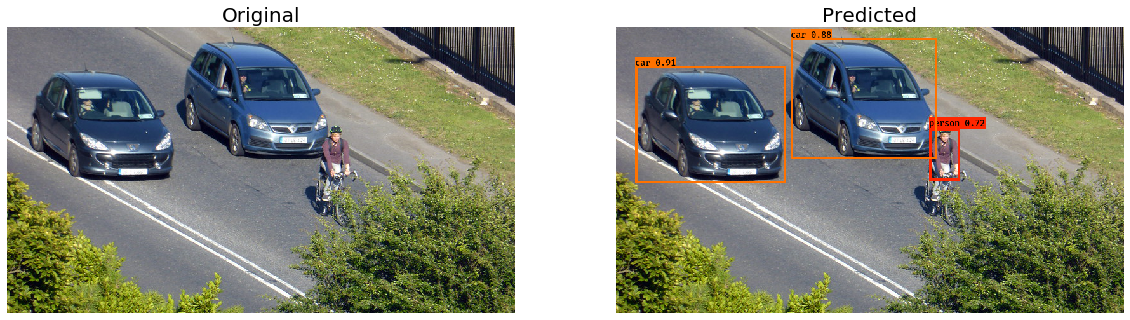

In [35]:
# Show the results

original_image = image.imread("images/" + image_name)

plt.figure(figsize=(20,20))

plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title('Original', fontsize = 20)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(predicted_image)
plt.title('Predicted', fontsize = 20)
plt.axis("off")

plt.show()

In [ ]:
K.clear_session()

## Visualized Object detection and classification with a YOLO pretrained model

To understand the functions we have defined, we have added here a visualization of the proceedings. The bounding boxes as returned from the model are visualized before they are filtered.

In [56]:
# Start a Session using Keras
sess = K.get_session()

### Define necessary variables

In [57]:
# Define the classes and anchors and image sizes
class_names = yolo_utils.read_classes("model_data/coco_classes.txt")
anchors = yolo_utils.read_anchors("model_data/yolo_anchors.txt")

In [58]:
# Define the image shape
image_shape = (450., 800.)

### Load the model

In [59]:
model = load_model("model_data/yolo.h5")

### Convert the models output into bounding boxes

In [60]:
outputs = yad2k.yolo_head(model.output, anchors, len(class_names))

### Filter the bounding boxes with no threshold and with a threshold
To show all bounding boxes we run the filter session, but give a low score threshold to show boxes with a low score (some even zero). Give a high iou threshold to not filter out using non_max_suppression.

In [61]:
# Change the thresholds here to see different results
max_box = 10
score_thres = 0.0
iou_thres = 0.0
scores, boxes, classes = evaluate(outputs, image_shape, max_boxes=max_box, score_threshold=score_thres, iou_threshold=0.0)

name, ending = image_name.split('.')
visualized_image = draw_boxes(image_name, name +'_visual', scores, boxes, classes, class_names)

# Use this to compute the final, filtered image
final_scores, final_boxes, final_classes = evaluate(outputs, image_shape, max_boxes=10)
predicted_image = draw_boxes(image_name, name +'_predicted', final_scores, final_boxes, final_classes, class_names)

TypeError: object of type 'Tensor' has no len()

### Run the session on an image

In [62]:
# Run on an image
image_name = "test_medium.jpg"
scores, boxes, classes = predict(sess, image_name)

C:\Users\maria\anaconda3\envs\easy_vehicle\lib\site-packages\ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':


NameError: name 'visualized_image' is not defined

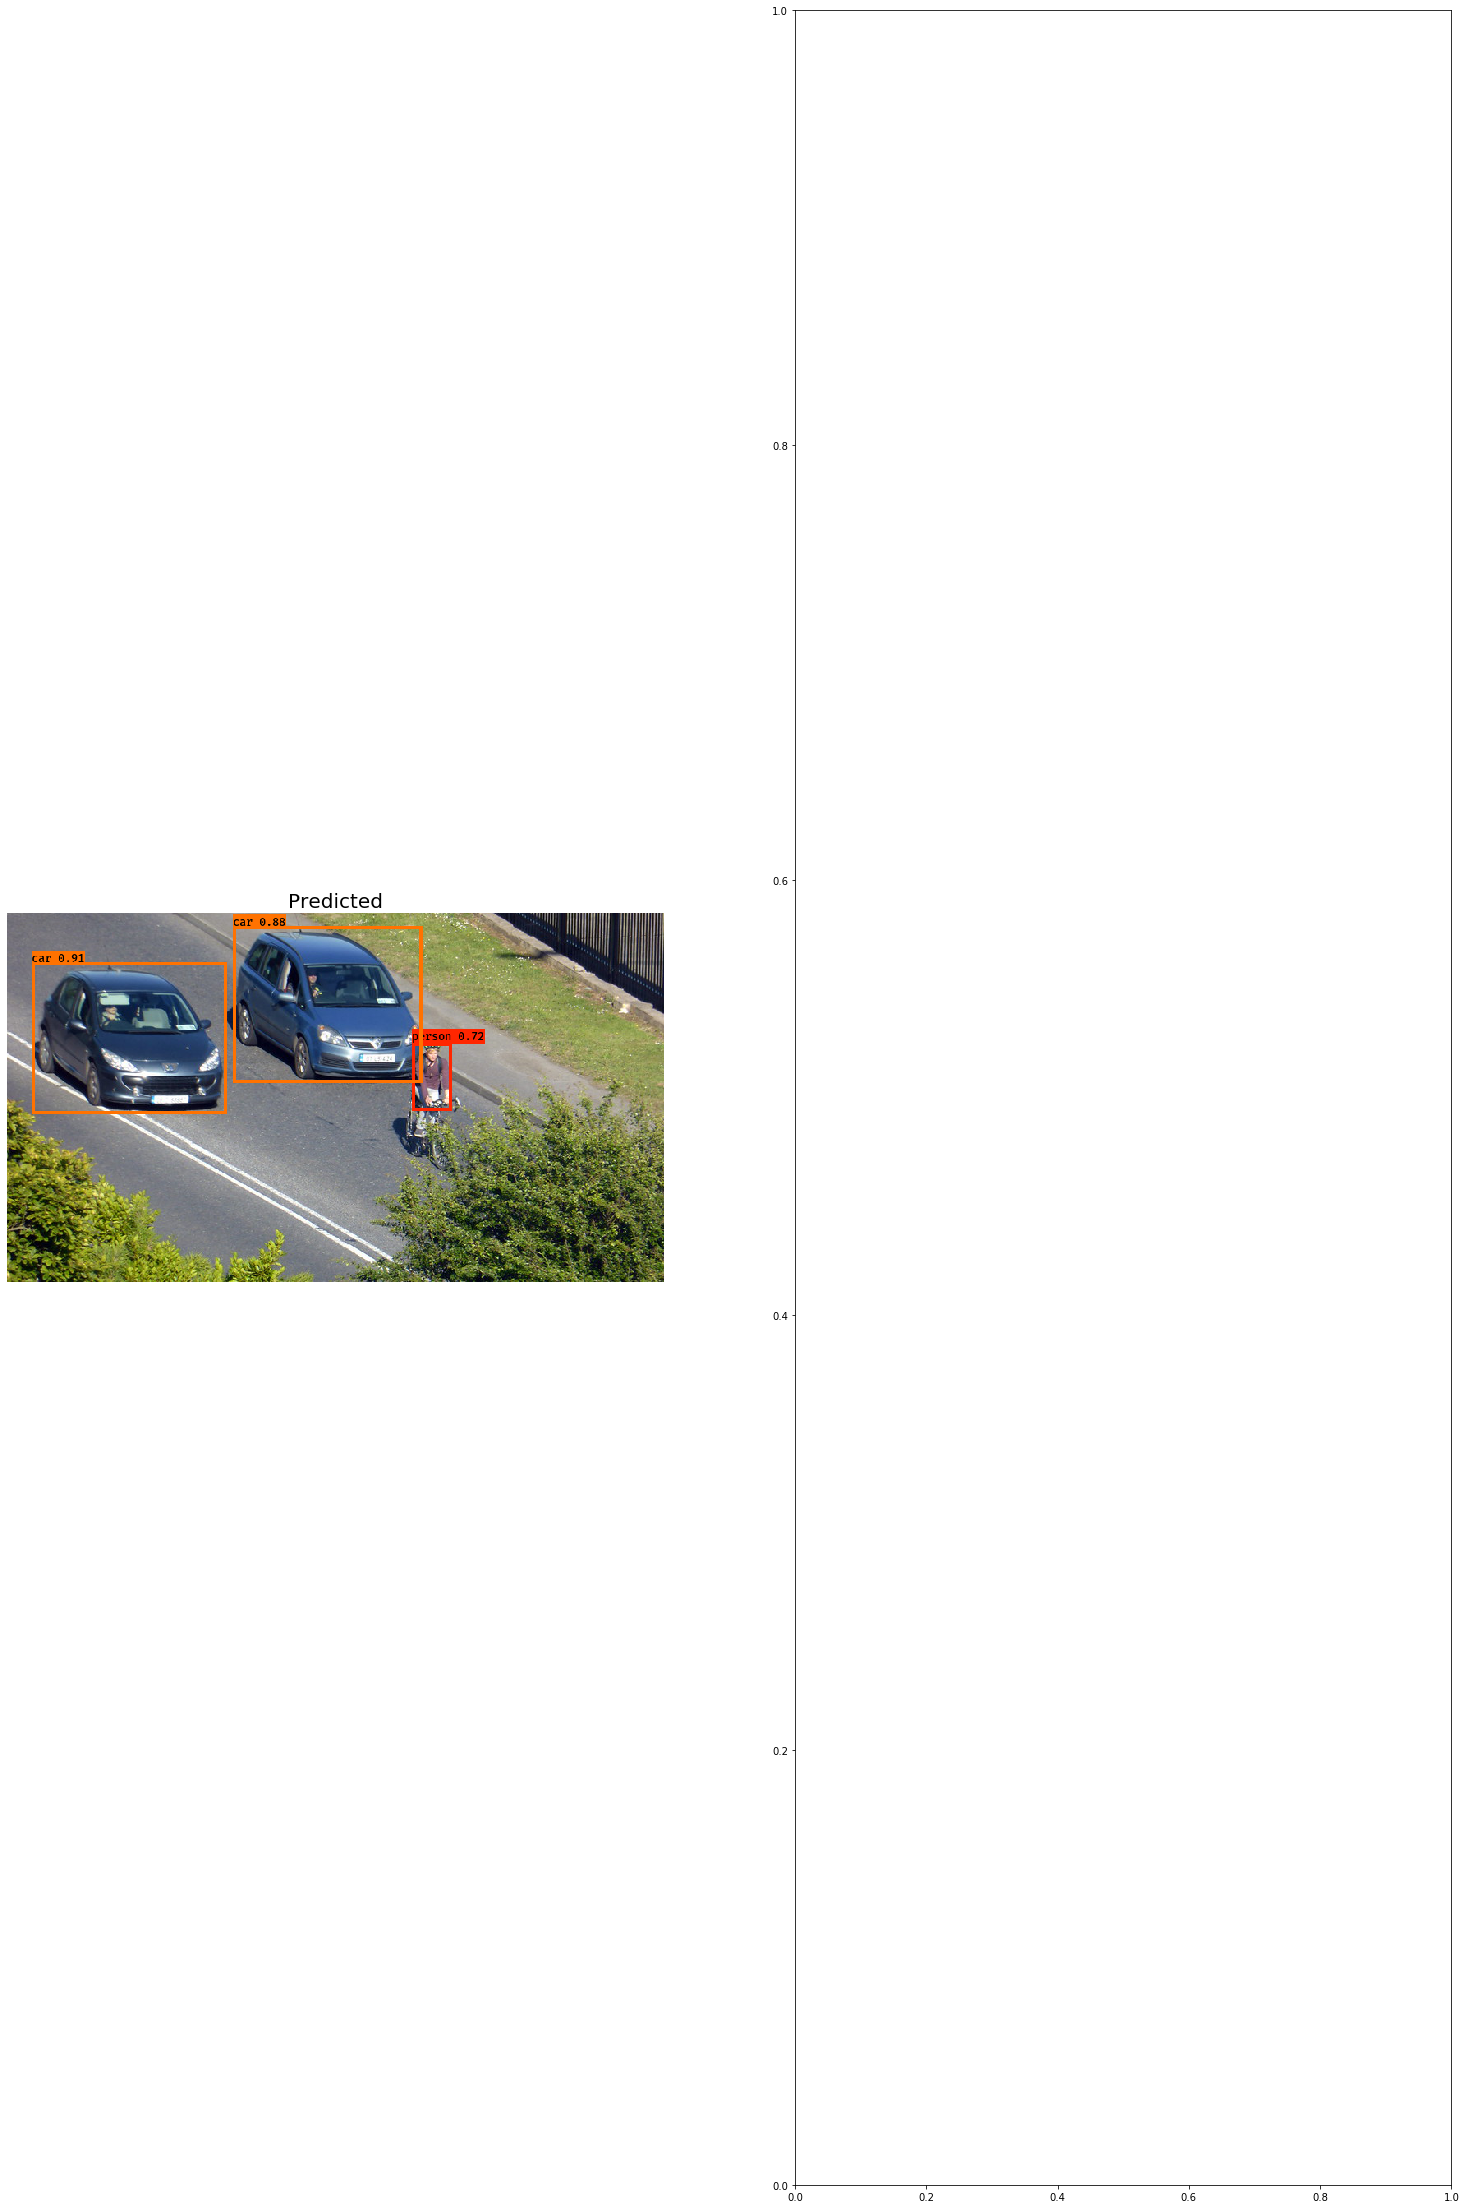

In [63]:
# Show the results

original_image = image.imread("images/" + image_name)

plt.figure(figsize=(40,40))

plt.subplot(1, 3, 1)
plt.imshow(original_image)
plt.title('Original', fontsize = 20)
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(predicted_image)
plt.title('Predicted', fontsize = 20)
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(visualized_image)
plt.title('Unfiltered', fontsize = 20)
plt.axis("off")


plt.show()

In [55]:
K.clear_session()

## Quellen
* [Intersection over Union (IoU)](https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/)
* [Hackernoon - Understanding YOLO](https://hackernoon.com/understanding-yolo-f5a74bbc7967)
* [YOLO Filter Boxes Walkthrough](https://mc.ai/yolo-filter-boxes-walkthrough/)
* [Autonomous Driving - Car detection](https://github.com/enggen/Deep-Learning-Coursera/blob/master/Convolutional%20Neural%20Networks/Week3/Car%20detection%20for%20Autonomous%20Driving/Autonomous%20driving%20application%20-%20Car%20detection%20-%20v1.ipynb)
* [(Faster) Non-Maximum Suppression Python](https://www.pyimagesearch.com/2015/02/16/faster-non-maximum-suppression-python/)
* [A Practical Guide to Object Detection using the YOLO Framework](https://www.analyticsvidhya.com/blog/2018/12/practical-guide-object-detection-yolo-framewor-python/)
* [Tensorflow Non Max Suppression (Documentation)](https://www.tensorflow.org/api_docs/python/tf/image/non_max_suppression)
* [YAD2K: Yet Another Darknet 2 Keras](https://github.com/allanzelener/YAD2K)
* [YAD2K keras_yolo.py](https://github.com/allanzelener/YAD2K/blob/master/yad2k/models/keras_yolo.py)
* [Deeplearning.ai](https://github.com/JudasDie/deeplearning.ai)
* [Deeplearning.ai yolo_utils.py](https://github.com/JudasDie/deeplearning.ai/blob/master/Convolutional%20Neural%20Networks/week3/yolo_utils.py)
* [Official YOLO Website](https://pjreddie.com/darknet/yolo/)
* [YOLO v3 theory explained](https://pylessons.medium.com/yolo-v3-theory-explained-33100f6d193)
* [YOLO V2 Implementation for object detection](https://medium.com/tech2xplore/quick-yolov2-implementation-for-object-detection-9073502bfe26)
* [A Comprehensive Guide to Object Detection Using YOLO Framework](https://towardsdatascience.com/object-detection-part2-6a265827efe1)
* [Create yolo.h5 model](https://github.com/JudasDie/deeplearning.ai/issues/2)
* [Test Image: "Traffic" by Sean MacEntee](https://www.flickr.com/photos/18090920@N07/20174044913)